# Intro to `tensorflow.keras` for regression

We'll use the `Keras` API included in `TensorFlow` to create a model that predicts velocity curves from synthetic seismic images. The dataset comes from a collection of synthetic seismic samples put together by Lukas Mosser and released on Github as [SNIST](https://github.com/LukasMosser/SNIST). This dataset intends to be a standard benchmark similiar to MNIST. We'll look at a basic model first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
urls = [
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_amplitudes.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_velocities.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_velocities.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_1.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_2.npy'
    ]

Numpy allows you to point at URL data sources. It'll take care of downloading them and keeping reference of where they are with respect to a root folder specified by the user.

In [4]:
ds = np.DataSource('../data/')

train_amplitudes = np.load(ds.open(urls[0], mode='rb'))
train_velocities = np.load(ds.open(urls[1], mode='rb'))

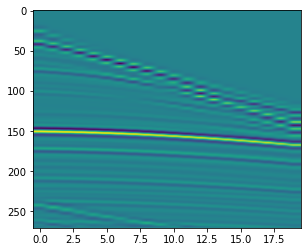

In [5]:
plt.imshow(train_amplitudes[0], aspect=0.06)

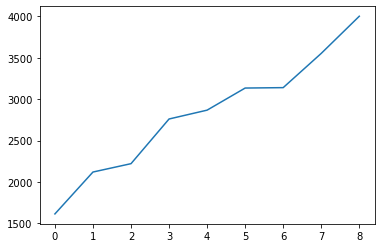

In [6]:
plt.plot(train_velocities[0])

Let's define some dataset parameters. Note that these come from the [SNIST](https://github.com/LukasMosser/SNIST) properties.

In [8]:
N_train = 600 #Number of total training examples
N_val = 150 #Number of samples used for validation
N_samples = 271 #Number of samples in time
N_recorders = 20 #Number of recording stations
N_layers = 9 #Number of layers in the target velocity model
N_z = 360 #Number of grid blocks in z-dimension (only used for visualisation)

Now some neural network parameters:

In [9]:
lr = 1e-2 #Learning rate
batch_size = N_train-N_val #Batchsize used in training - do full batch evaluation because of small data
N_epochs = 200 #Number of epochs to train for

We'll use Tensorflow's Keras functionality to setup a single layer network as baseline.

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

In [11]:
tf.version.VERSION

'2.1.0'

Let's define a single layer network using `tf.keras.models` and `tf.keras.layers`.

In [18]:
model = tf.keras.models.Sequential()

model.add(Dense(N_recorders*N_samples, input_dim=N_recorders*N_samples, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(N_layers))

# Let's define an optimizer
opt = SGD(lr=1e-2)

model.compile(loss='mse',
              optimizer=opt,
              metrics=['mae'])

We'll need to standarize the input and normalize the output values

In [19]:
train_mean, train_std = train_amplitudes.mean(), train_amplitudes.std()
train_vel_max = train_velocities.max()

In [20]:
X = train_amplitudes - train_mean
X /= train_std

y = train_velocities / train_vel_max

X_train = X[:-N_val]
y_train = y[:-N_val]


X_test = X[N_train-N_val:]
y_test = y[N_train-N_val:]

Let's confirm that the shapes of these matrices are OK:

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((450, 271, 20), (450, 9), (150, 271, 20), (150, 9))

We want to make the training data to be 1D to be allowed through this fully connected neural network.

In [22]:
X_train = X_train.reshape((N_train-N_val, N_samples*N_recorders))
X_test = X_test.reshape((N_val, N_samples*N_recorders))

In theory we could just do `model.fit(X_train, y_train)` and be done with it. But it's useful to setup a log system and callbacks to monitor the progress and quality of the training run. We'll use a tool called `Tensorboard` that is part of the `TensorFlow` ecosystem to visualize training runs.

We'll setup a folder to store the training logs for `TensorBoard`. They'll be different for each training run based on the time and date but this particular setup is not a requirement.

In [23]:
curr_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(
    "logs",
    "fit",
    curr_date,
)
log_dir

'logs/fit/20200513-122155'

We can train the network an setup a few useful callbacks that will be executed after each training epoch ends:
 - A `Tensorboard` callback to generate and write the logs
 - An "early stopping" callback to allow training to stop if the loss doesn't improve after `patience` number of epochs
 - A model checkpoint callback to save, in this case, the best model based on the loss value.


In [24]:
model_name = 'seis_vel'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(f'{log_dir}/{model_name}.h5', monitor='val_loss', verbose=1, save_best_only=True)


model.fit(X_train, y_train,
          epochs=10,
          batch_size=N_train,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback,
                     es_callback,
                     checkpoint_callback,
                    ],
         )

Train on 450 samples, validate on 150 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.23224, saving model to logs/fit/20200513-122155/seis_vel.h5
450/450 [==============================] - 3s 6ms/sample - loss: 0.3203 - mae: 0.4414 - val_loss: 0.2322 - val_mae: 0.3821
Epoch 2/10

Epoch 00002: val_loss improved from 0.23224 to 0.16290, saving model to logs/fit/20200513-122155/seis_vel.h5
450/450 [==============================] - 2s 6ms/sample - loss: 0.2143 - mae: 0.3667 - val_loss: 0.1629 - val_mae: 0.3233
Epoch 3/10

Epoch 00003: val_loss improved from 0.16290 to 0.11901, saving model to logs/fit/20200513-122155/seis_vel.h5
450/450 [==============================] - 3s 6ms/sample - loss: 0.1485 - mae: 0.3090 - val_loss: 0.1190 - val_mae: 0.2778
Epoch 4/10

Epoch 00004: val_loss improved from 0.11901 to 0.09032, saving model to logs/fit/20200513-122155/seis_vel.h5
450/450 [==============================] - 2s 6ms/sample - loss: 0.1072 - mae: 0.2642 - val_loss: 0.0903 

To activate `Tensorboard` and monitor the directory created above, go to a terminal and cd into the `notebooks` folder of the course material. Once in there, execute this command: `tensorboard --logdir 'path/defined/above'`

We still have access to the history of training through methods in the `model` object.

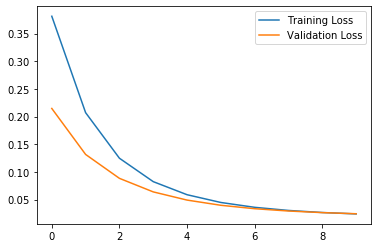

In [20]:
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()

We can make predictions with the trained model:

In [21]:
y_pred = model.predict(X_test[0].reshape(1,*X_test[0].shape))

What if we want to load a pre-trained model?

In [22]:
model.load_weights(f'logs/fit/{curr_date}/seis_vel.h5')
y_pred = model.predict(X_test[0].reshape(1,*X_test[0].shape))

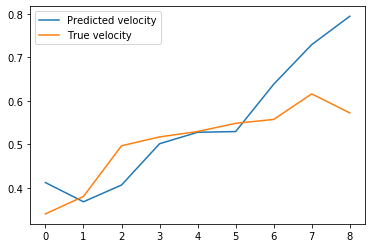

In [23]:
plt.plot(y_pred[0], label='Predicted velocity')
plt.plot(y_test[0], label='True velocity')
plt.legend()

### Exercise

- Create another model with more layers and more neurons per layer and train it using the same training data. Is it any better?

In [ ]:
# put your code here

### Exercise

- This model needs validation. Compute the apropriate metrics to assess the quality of the predictions made by this model. You can use `scikit-learn` to support these calculations.
- Use a `scikit-learn` `RandomForest` model to compare the predictions of the neural network we just trained.

In [ ]:
# put your code here

# How about a Convolutional Neural Network?
Yeah but what'as a Convolutional Neural Network?
 - Keep these cheatsheets at hand: https://github.com/afshinea/stanford-cs-230-deep-learning
 
![alt text](../images/convolution-layer-a.png)

In [18]:
model = tf.keras.Sequential()# Must define the input shape in the first layer of the neural network

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='elu', input_shape=(N_samples, N_recorders, 1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_layers))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 271, 20, 64)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 10, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 135, 10, 32)       8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 67, 5, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2744576   
_________________________________________________________________
dropout (Dropout)            (None, 256)              

## What's max-pooling?
![alt text](../images/max-pooling-a.png)

In [21]:
model.compile(loss='mse',
              optimizer=opt,
              metrics=['mae'])

To take full advantage of a convolutional neural network, the training data has to maintain its spatial relationships. In this case, the 2D images shouldn't be serialized. When this is the case, `keras` requires the training images to be in a very specific shape: (n_image, width, height, n_channels).

In [22]:
X_train = X_train.reshape((N_train-N_val, N_samples, N_recorders, 1))
X_test = X_test.reshape((N_val, N_samples, N_recorders, 1))

In [23]:
X_train.shape

(450, 271, 20, 1)

### Exercise

- We're ready to train a model but the next cell is missing any history logging, model saving or ways to stop training if performance is not improved after a few epochs. Add the appropriate code to deal with this and monitor the training progress using `Tensorboard`.

In [24]:
#!--
curr_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(
    "logs_CNN",
    "fit",
    curr_date,
)

model_name = 'seis_vel_CNN'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(f'{log_dir}/{model_name}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#--!
model.fit(X_train, y_train,
          epochs=10,
          batch_size=N_train,
          validation_data=(X_test, y_test),
         )

Train on 450 samples, validate on 150 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.34083, saving model to logs_CNN\fit\20190905-132335/seis_vel_CNN.h5
450/450 [==============================] - 2s 5ms/sample - loss: 0.4292 - mae: 0.5920 - val_loss: 0.3408 - val_mae: 0.5422
Epoch 2/10

Epoch 00002: val_loss improved from 0.34083 to 0.27493, saving model to logs_CNN\fit\20190905-132335/seis_vel_CNN.h5
450/450 [==============================] - 2s 4ms/sample - loss: 0.3477 - mae: 0.5286 - val_loss: 0.2749 - val_mae: 0.4850
Epoch 3/10

Epoch 00003: val_loss improved from 0.27493 to 0.22571, saving model to logs_CNN\fit\20190905-132335/seis_vel_CNN.h5
450/450 [==============================] - 2s 4ms/sample - loss: 0.2778 - mae: 0.4685 - val_loss: 0.2257 - val_mae: 0.4367
Epoch 4/10

Epoch 00004: val_loss improved from 0.22571 to 0.18618, saving model to logs_CNN\fit\20190905-132335/seis_vel_CNN.h5
450/450 [==============================] - 2s 4ms/sample - loss: 0.2412 -

In [25]:
y_pred = model.predict(X_test[0].reshape(1,*X_test[0].shape))

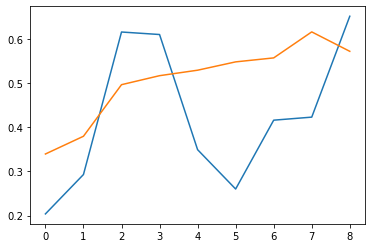

In [26]:
plt.plot(y_pred[0])
plt.plot(y_test[0])